# Demo - Gaussianization Flow

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
# import wandb

# wandb_logger = wandb.init(project="gf_plane_splines", entity="ipl_uv")

# wandb_logger.config.seed = 123

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
from rbig_jax.data import CheckBoard as PlaneDataset
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(n_train: int, batch_size: int, seed: int) -> Iterator[Batch]:
    ds = PlaneDataset(n_samples=n_train, noise=0.1, seed=seed)
    ds = tf.data.Dataset.from_tensor_slices(ds[:])
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [5]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 5_000
n_train = 5_000
train_ds = load_dataset(n_train, 128, 123)
init_ds = load_dataset(n_init_samples, n_init_samples, 123)
valid_ds = load_dataset(1_000, 128, 123 + 100)

In [6]:
# demo batch
demo_batch = next(init_ds)

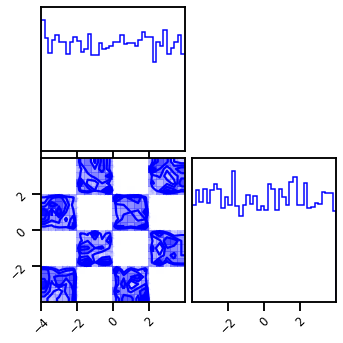

In [7]:
# plot data
fig = corner.corner(demo_batch, color="blue", hist_bin_factor=2)

In [8]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch) -> Array:

    # select image from tfds
    batch = batch.astype(jnp.float32)

    return batch

## Model

In [69]:
from rbig_jax.models.gaussflow import (
    init_gf_composite_spline_model,
    init_gf_spline_model,
)

X = jnp.array(demo_batch[:], dtype=np.float32)

# marginal uniformization
n_bins = 32
range_min = -12
range_max = 12
boundary_slopes = "unconstrained"
identity_init = False

# rotation transformation
n_reflections = 2
init_rotation = "random"

# nn params
n_blocks = 8
squeeze = "sigmoid"

X_init = np.array(X)

In [70]:
# init model
gf_model = init_gf_spline_model(
    shape=X.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
    #     squeeze=squeeze,
)

Initializing - Block: 8 | Layer 15: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


In [71]:
X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

# gf_model.score(X_init)

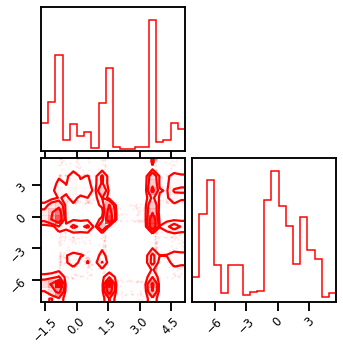

In [72]:
fig = corner.corner(np.array(X_g), color="Red")
plt.show()

#### Training

In [73]:
from chex import dataclass


def loss_fn(model: dataclass, batch: Batch) -> Array:

    # negative log likelihood loss
    nll_loss = model.score(batch)

    return nll_loss


@jax.jit
def eval_fn(model: dataclass, batch: Batch) -> Array:

    # negative log likelihood loss
    nll_loss = model.score(batch)

    return nll_loss

In [74]:
nll_loss = loss_fn(gf_model, demo_batch)
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")
nll_loss = eval_fn(gf_model, demo_batch)
print(f"Initial NLL Loss (Eval): {nll_loss:.4f}")

Initial NLL Loss (Train): 14.2987
Initial NLL Loss (Eval): 14.2987


### Optimizer

* weight decay = 1e-4
* cosine_decay = True
* warmup ratio = 0.
* batch size = 128

* gradient value clip = 1
* learning rate = 1e-4
* optimizer = adam


In [75]:
import optax

# optimizer params
epochs = 15_000  # 12_000
eval_frequency = 50
learning_rate = 1e-4

# intialize optimizer
# optimizer = optax.adam(learning_rate=learning_rate)
optimizer = optax.chain(
    #     optax.clip_by_global_norm(0.25),
    optax.clip(1.0),
    optax.adam(learning_rate, b1=0.9, b2=0.99, eps=1e-5),
    #     optax.scale_by_schedule(
    #         optax.cosine_onecycle_schedule(
    #             transition_steps=n_train * epochs,
    #             peak_value=learning_rate,
    #             pct_start=0.3,
    #             div_factor=10.0,
    #             final_div_factor=1e4,
    #         )
    #     ),
)

# intialize optimizer state
opt_state = optimizer.init(gf_model)

### Train Step

In [76]:
from typing import Tuple, Any

OptState = Any


@jax.jit
def update(
    params: dataclass, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Train Loop

In [77]:
# # split the keys into a unique subset
# train_rng = jax.random.split(rng, num=epochs)

# # create an iterator
# train_rng = iter(train_rng)

In [78]:
metrics = {
    "train_step": list(),
    "train_loss": list(),
    "valid_step": list(),
    "valid_loss": list(),
}


eval_loss = 0.0

In [79]:
# %%wandb

import tqdm


with tqdm.trange(epochs) as pbar:
    for step in pbar:
        gf_model, opt_state, loss = update(gf_model, opt_state, next(train_ds))

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        #         wandb.log({"train_loss": float(loss), "training_step": step})
        metrics["train_step"].append(step)
        metrics["train_loss"].append(loss)

        if step % eval_frequency == 0:
            eval_loss = eval_fn(gf_model, next(valid_ds))

            pbar.set_description(
                f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )
            #             wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            metrics["valid_step"].append(step)
            metrics["valid_loss"].append(eval_loss)

Train Loss: 3.8119 | Valid Loss: 3.9207: 100%|██████████| 15000/15000 [02:18<00:00, 108.27it/s] 


### Results

#### Losses

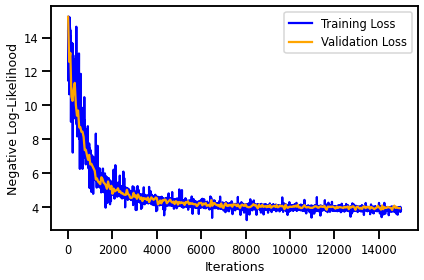

In [80]:
fig, ax = plt.subplots()
ax.plot(
    metrics["train_step"], metrics["train_loss"], label="Training Loss", color="blue"
)
ax.plot(
    metrics["valid_step"],
    metrics["valid_loss"],
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

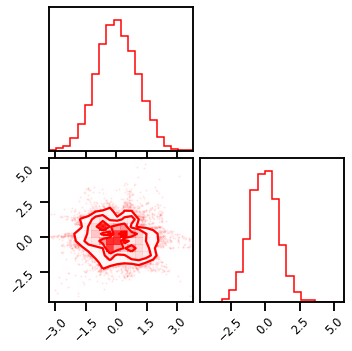

CPU times: user 2.84 s, sys: 119 ms, total: 2.96 s
Wall time: 2.74 s


In [81]:
%%time
n_eval_samples = 10_000
eval_ds = load_dataset(n_eval_samples, n_eval_samples, 200)
eval_ds =next(eval_ds)
X_trans = gf_model.forward(eval_ds)

fig = corner.corner(np.array(X_trans), color="Red")
plt.show()

#### Inverse Transform

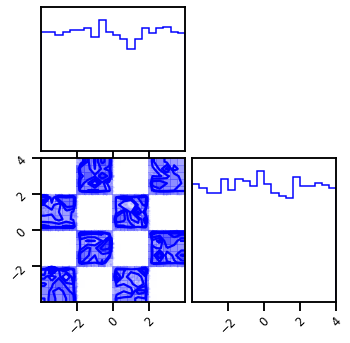

CPU times: user 2.33 s, sys: 83.3 ms, total: 2.41 s
Wall time: 2.19 s


In [82]:
%%time

X_approx = gf_model.inverse(X_trans)

fig = corner.corner(np.array(X_approx), color="Blue")
plt.show()

### Log Probability

#### Plot: Original Density

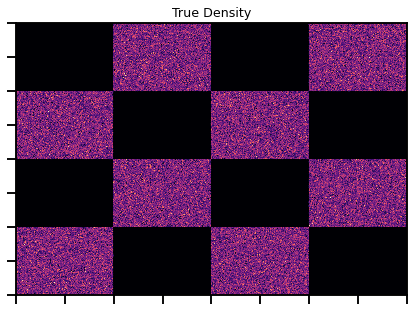

In [83]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 1_000_000
ds_plot = PlaneDataset(n_samples=n_samples, noise=0.1, seed=100)
X_plot = ds_plot[:]


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [84]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points

xyinput = generate_2d_grid(next(init_ds), 500, buffer=0.2)

# calculate log probability
X_log_prob = gf_model.score_samples(xyinput)

CPU times: user 4.11 s, sys: 442 ms, total: 4.56 s
Wall time: 2.35 s


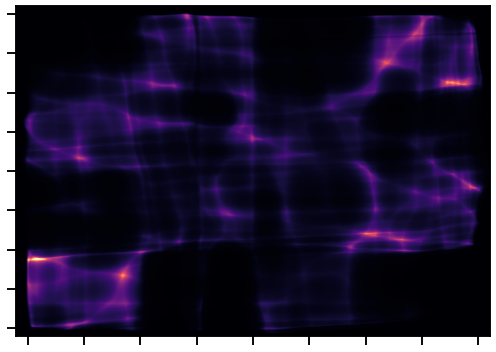

In [85]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(figsize=(7, 5))

h1 = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=0.2
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.show()

### Sampling

In [86]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

In [87]:
%%time

n_gen_samples = 100_000

X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 3.28 s, sys: 315 ms, total: 3.59 s
Wall time: 2.43 s


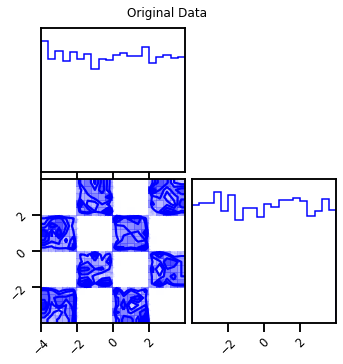

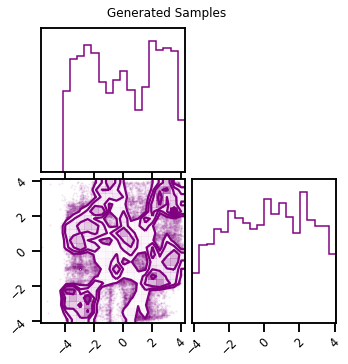

In [88]:
fig = corner.corner(np.array(X), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Original

In [89]:
# X_g = X.copy()

# fig = corner.corner(X_g, color="purple")
# fig.suptitle("Initial")
# plt.show()

# for ilayer, ibijector in enumerate(gf_model.bijectors):

#     X_g = ibijector.forward(X_g)

#     if (ilayer+1) % 3 == 0:
#         fig = corner.corner(X_g, color="purple")
#         fig.suptitle(f"Block: {(ilayer+1)//3}")
#         plt.show()

#### Trained Model

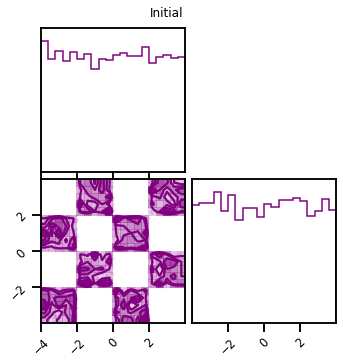

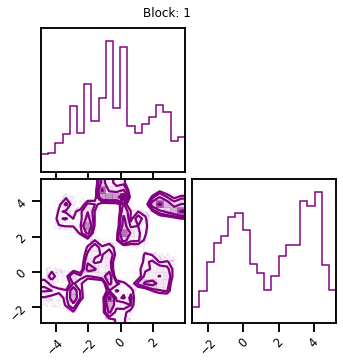

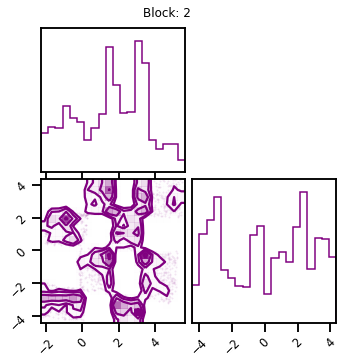

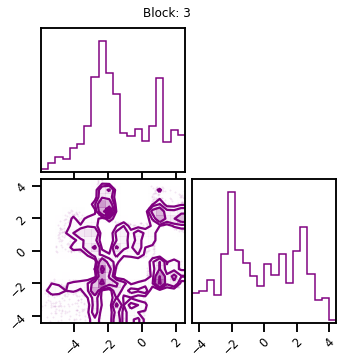

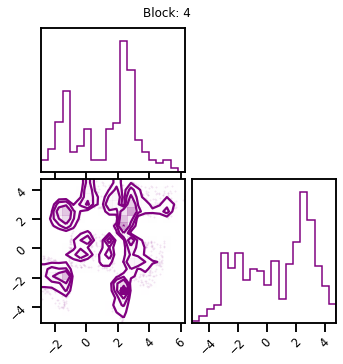

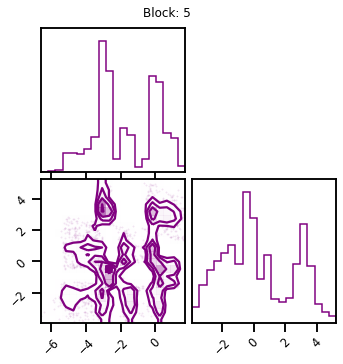

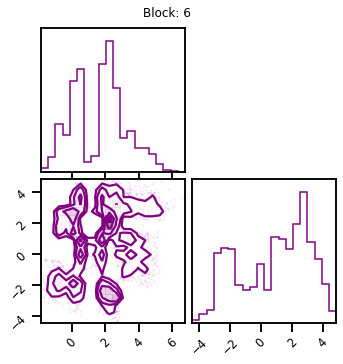

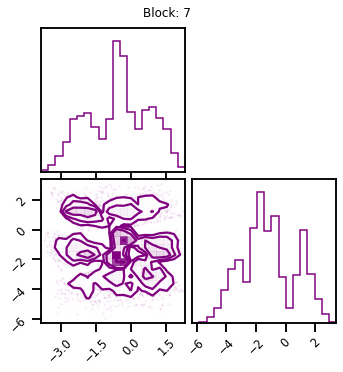

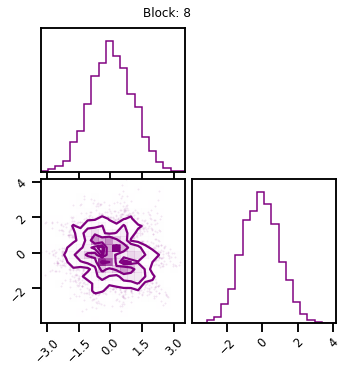

In [90]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//2}")
        plt.show()

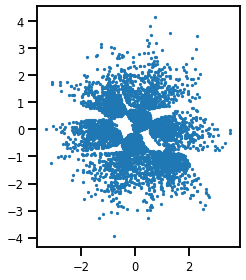

In [91]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

In [78]:
import pickle

#### Save Model

In [79]:
import joblib

joblib.dump(final_bijector, "gf_model_spline.pickle")

['gf_model_spline.pickle']

#### Load Model

In [80]:
gf_model_loaded = joblib.load("gf_model_spline.pickle")